# Supplementary Figure for Fig1: Evaluate effect of different subsampling fractions on leiden clustering

Question:
- how many pixels do we need to sample to get a stable clustering result?
- how large is variation due to different leiden seeds and due to different subsampling seeds?

Approach:
- test different orders of magnitude to sample pixels for leiden clustering
- calculate each subset + clustering several times with different seeds
- compare clusterings of different subsets (stability) and clusterings done with different amounts of pixels (correct number of subsampled pixels)
- compare to annotated "groundtruth" clustering

Alternatives:
- could compute scores of variation with clustering + subsampling and compare against variation of clustering only. Did this and does not change results

In [1]:
from campa.tl import Cluster
from campa.data import MPPData
from campa_ana.constants import SOURCE_DIR
import os
import numpy as np
import seaborn as sns
from pathlib import Path
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from campa.constants import campa_config
from sklearn import metrics

# plot 
sns.set_style('white')
sns.set_context('talk')

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
clus = Cluster.from_cluster_data_dir('VAE_all/CondVAE_pert-CC/aggregated/sub-0.001')
clus.set_cluster_name('clustering_res0.5')

In [4]:
print(clus.cluster_mpp.data('latent').shape)
display(clus.config)

(154906, 16)


{'data_config': 'NascentRNA',
 'data_dirs': ['184A1_unperturbed/I09',
  '184A1_unperturbed/I11',
  '184A1_unperturbed/J10',
  '184A1_unperturbed/J12',
  '184A1_DMSO/I14',
  '184A1_DMSO/J16',
  '184A1_AZD4573/I13',
  '184A1_AZD4573/I17',
  '184A1_AZD4573/J14',
  '184A1_AZD4573/J18',
  '184A1_AZD4573/J21',
  '184A1_CX5461/I18',
  '184A1_CX5461/J09',
  '184A1_CX5461/J22',
  '184A1_TSA/I16',
  '184A1_TSA/J13',
  '184A1_TSA/J20',
  '184A1_triptolide/I10',
  '184A1_triptolide/J15',
  '184A1_meayamycin/I12',
  '184A1_meayamycin/I20'],
 'process_like_dataset': '184A1_all_frac0005_neigh3_cond_pert-CC',
 'subsample': True,
 'subsample_kwargs': {'frac': 0.001},
 'subset': False,
 'subset_kwargs': {},
 'seed': 42,
 'cluster_data_dir': 'VAE_all/CondVAE_pert-CC/aggregated/sub-0.001',
 'cluster_name': 'clustering_res0.5',
 'cluster_rep': 'latent',
 'cluster_method': 'leiden',
 'leiden_resolution': 0.8,
 'kmeans_n': 20,
 'umap': True,
 'som_kwargs': {},
 'predict_cluster_imgs': True}

## get different subsets for clustering
- differently sized subsets
- repeat with different seeds for subsampling to get an idea of the variation in the clustering

In [42]:
seeds = [0,1,2,3,4]
nums = [300000,len(clus.cluster_mpp.data('latent')),75000,37000,19000,9300,4600,2300,1100]
nums_per_data_dir = [int(n/len(clus.config['data_dirs'])) for n in nums]

data = {num: [[] for _ in seeds] for num in nums}
for data_dir in clus.config['data_dirs']:
    print(data_dir)
    # load data
    mpp_data = MPPData.from_data_dir(os.path.join('VAE_all/CondVAE_pert-CC/aggregated', 'full_data', data_dir), keys=['latent'], base_dir=campa_config.EXPERIMENT_DIR)
    # subsample latent
    for num in nums:
        n = int(num/len(clus.config['data_dirs']))
        for i, seed in enumerate(seeds):
            rng = np.random.RandomState(seed=seed)
            selected = rng.choice(len(mpp_data.data('latent')), n, replace=False)
            data[num][i].append(mpp_data.data('latent')[selected])
    

184A1_unperturbed/I09
184A1_unperturbed/I11
184A1_unperturbed/J10
184A1_unperturbed/J12
184A1_DMSO/I14
184A1_DMSO/J16
184A1_AZD4573/I13
184A1_AZD4573/I17
184A1_AZD4573/J14
184A1_AZD4573/J18
184A1_AZD4573/J21
184A1_CX5461/I18
184A1_CX5461/J09
184A1_CX5461/J22
184A1_TSA/I16
184A1_TSA/J13
184A1_TSA/J20
184A1_triptolide/I10
184A1_triptolide/J15
184A1_meayamycin/I12
184A1_meayamycin/I20


In [46]:
# save data
pickle.dump(data, open(os.path.join(fig_dir, 'subsampled_data.pickle'), 'wb'))

## cluster and project result to reference subsample

In [8]:
data = pickle.load(open(os.path.join(fig_dir, 'subsampled_data.pickle'), 'rb'))

# join all data_dirs
seeds = [0,1,2,3,4]
nums = [300000,len(clus.cluster_mpp.data('latent')),75000,37000,19000,9300,4600,2300,1100]
for num in nums:
    for i in range(len(seeds)):
        data[num][i] = np.concatenate(data[num][i])

In [9]:
from pynndescent import NNDescent
def project_clustering(samples, from_samples, from_clusters):
    index = NNDescent(from_samples)
    # func for getting max count cluster in each row
    def most_frequent(arr):
        els, counts = np.unique(arr, return_counts=True)
        return els[np.argmax(counts)]
    # project clusters
    neighs = index.query(samples, k=15)[0]
    projected_clusters = np.apply_along_axis(most_frequent, arr=np.array(from_clusters)[neighs], axis=1)
    return projected_clusters

In [11]:
resolution = 0.5
# when varying sub_seed, fix leiden_seeds to 0; do not need all combinations. UPDATE: yes, do want all combinations to do more stats (but first only for 2 subsample sizes)
#leiden_seeds = [0] 
leiden_seeds = [1, 2, 3, 4]
#sub_seeds = [0,1,2,3,4] 
sub_seeds = [1,2,3,4]

if os.path.exists(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv')):
    df = pd.read_csv(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv'), index_col=0)
else:
    df = None
    
for num in nums:
    for sub_seed in sub_seeds:
        if num in [300000,len(clus.cluster_mpp.data('latent')),75000, 37000]:
            continue
        print(num)
        adata = ad.AnnData(data[num][sub_seed])
        sc.pp.neighbors(adata)
        for seed in leiden_seeds:
            print(num, seed, sub_seed)
            sc.tl.leiden(adata, resolution=resolution, key_added='clustering', random_state=seed)
            cl = adata.obs['clustering']
            # project to reference
            proj_cl = project_clustering(clus.cluster_mpp.data('latent'), from_samples=adata.X, from_clusters=cl)
            if df is None:
                df = pd.DataFrame(proj_cl, columns=[f'cl_{num}_{seed}_sub{sub_seed}'])
            else:
                df[f'cl_{num}_{seed}_sub{sub_seed}'] = proj_cl
            df.to_csv(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv'))
 

19000
19000 1 1
19000 2 1
19000 3 1
19000 4 1
19000
19000 1 2
19000 2 2
19000 3 2
19000 4 2
19000
19000 1 3
19000 2 3
19000 3 3
19000 4 3
19000
19000 1 4
19000 2 4
19000 3 4
19000 4 4
9300
9300 1 1
9300 2 1
9300 3 1
9300 4 1
9300
9300 1 2
9300 2 2
9300 3 2
9300 4 2
9300
9300 1 3
9300 2 3
9300 3 3
9300 4 3
9300
9300 1 4
9300 2 4
9300 3 4
9300 4 4
4600
4600 1 1
4600 2 1
4600 3 1
4600 4 1
4600
4600 1 2
4600 2 2
4600 3 2
4600 4 2
4600
4600 1 3
4600 2 3
4600 3 3
4600 4 3
4600
4600 1 4
4600 2 4
4600 3 4
4600 4 4
2300
2300 1 1
2300 2 1
2300 3 1
2300 4 1
2300
2300 1 2
2300 2 2
2300 3 2
2300 4 2
2300
2300 1 3
2300 2 3
2300 3 3
2300 4 3
2300
2300 1 4
2300 2 4
2300 3 4
2300 4 4
1100
1100 1 1
1100 2 1
1100 3 1
1100 4 1
1100
1100 1 2
1100 2 2
1100 3 2
1100 4 2
1100
1100 1 3
1100 2 3
1100 3 3
1100 4 3
1100
1100 1 4
1100 2 4
1100 3 4
1100 4 4


## compare cluster overlap with reference clustering
as leiden clustering itself varies a lot wrt different random seeds, we have to compare the subsampling variation with the expected random leiden variation (from the same subset)
- to judge how stable a clustering is, calculate cluster overlap scores between all pairs and take mean of resulting scores
- then compare these score distributions of the leiden seed variation to the subsampling variation

plot ideas
1. compute mean + ci of overlap within one size (num). Compare variation due to leiden with variation due to sampling. Plot line plot of 2 kinds of variation + ci 095 against num
2. which clusters are mostly varying at chosen num. compare overlap scores for each cluster (again for sampling + leiden variation) and plot per cluster. calculate homogeneity per label as a score for this (high homogeneity if clusers are either label 1 or label 0) 

compare MI intra sub (sub0 vs sub0) with MI inter sub (sub0 vs sub1). Do point plots with CI 095. Optionally calculate significance (with ttest?)

In [5]:
df = pd.read_csv(fig_dir/'cluster_subsamples_on_reference.csv', index_col=0)

### Old: calculate var_sub, var_leiden

In [37]:
# calculate scores between clustering and reference cluster
cl_list = [c for c in df.columns if 'cl_' in c]

print('varsub')
res_varsub = {
    'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': []
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if leiden_seed != '0':
        continue
    print(num, leiden_seed, sub_seed)
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if leiden_seed2 != '0':
            continue
        if num != num2:
            continue
        print('--', num2, leiden_seed2, sub_seed2)
        res_varsub['num'].append(num)
        res_varsub['c1'].append(c1)
        res_varsub['c2'].append(c2)
        res_varsub['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        res_varsub['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))
        
print('varleiden')
res_varleiden = {
    'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': []
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if sub_seed != 'sub0':
        continue
    print(num,leiden_seed,sub_seed)
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if sub_seed2 != 'sub0':
            continue
        if num != num2:
            continue
        print('--', num2, leiden_seed2, sub_seed2)
        #if leiden_seed not in ['0','1']:
        #    continue
        res_varleiden['num'].append(num)
        res_varleiden['c1'].append(c1)
        res_varleiden['c2'].append(c2)
        res_varleiden['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        res_varleiden['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))
        
df_varleiden = pd.DataFrame(res_varleiden)
df_varleiden['num'] = df_varleiden['num'].astype(int)
df_varsub = pd.DataFrame(res_varsub)
df_varsub['num'] = df_varsub['num'].astype(int)

df_varleiden.to_csv(fig_dir/'leiden_subsampling_varleiden.csv')
df_varsub.to_csv(fig_dir/'leiden_subsampling_varsub.csv')

varsub
9300 0 sub0
-- 9300 0 sub0
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
9300 0 sub1
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
9300 0 sub2
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
9300 0 sub3
-- 9300 0 sub3
-- 9300 0 sub4
9300 0 sub4
-- 9300 0 sub4
4600 0 sub0
-- 4600 0 sub0
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
4600 0 sub1
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
4600 0 sub2
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
4600 0 sub3
-- 4600 0 sub3
-- 4600 0 sub4
4600 0 sub4
-- 4600 0 sub4
2300 0 sub0
-- 2300 0 sub0
-- 2300 0 sub1
-- 2300 0 sub2
-- 2300 0 sub3
-- 2300 0 sub4
2300 0 sub1
-- 2300 0 sub1
-- 2300 0 sub2
-- 2300 0 sub3
-- 2300 0 sub4
2300 0 sub2
-- 2300 0 sub2
-- 2300 0 sub3
-- 2300 0 sub4
2300 0 sub3
-- 2300 0 sub3
-- 2300 0 sub4
2300 0 sub4
-- 2300 0 sub4
1100 0 sub0
-- 1100 0 sub0
-- 1100 0 sub1
-- 1100 0 sub2
-- 1100 0 sub3
-- 1100 0 sub4
1100 0 sub1
-- 1100 0 sub1
-- 1100 0 sub2
-- 1100 0

In [38]:
# alternative: varleiden compared to varsubleiden (combine samples for subsampling)
# calculate varsubleiden
cl_list = [c for c in df.columns if 'cl_' in c]

print('varsubleiden')
res_varsubleiden = {
    'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': []
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    print(num, leiden_seed, sub_seed)
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if num != num2:
            continue
        print('--', num2, leiden_seed2, sub_seed2)
        res_varsubleiden['num'].append(num)
        res_varsubleiden['c1'].append(c1)
        res_varsubleiden['c2'].append(c2)
        res_varsubleiden['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        res_varsubleiden['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))

df_varsubleiden = pd.DataFrame(res_varsubleiden)
df_varsubleiden['num'] = df_varsubleiden['num'].astype(int)
df_varsubleiden.to_csv(fig_dir/'leiden_subsampling_varsubleiden.csv')


varsubleiden
9300 0 sub0
-- 9300 0 sub0
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub1
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub2
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub3
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub4
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
4600 0 sub0
-- 4600 0 sub0
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0 sub1
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0 sub2
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0

### OLD: calculate leiden cluster and subsampling variation (mutual information)

In [35]:
# calculate scores between clustering and reference cluster
cl_list = [c for c in df.columns if 'cl_' in c]

var = {
    #'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': [],
    'leiden_seed1': [],
    'sub_seed1': [],
    'leiden_seed2': [],
    'sub_seed2': [],
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    print(num, leiden_seed, sub_seed)
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if num != num2: # only compare clusters with same num of samples
            continue
        print('--', num2, leiden_seed2, sub_seed2)
        var['num'].append(num)
        var['c1'].append(c1)
        var['c2'].append(c2)
        var['leiden_seed1'].append(leiden_seed)
        var['sub_seed1'].append(sub_seed)
        var['leiden_seed2'].append(leiden_seed2)
        var['sub_seed2'].append(sub_seed2)
        #var['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        var['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))
        

9300 0 sub0
-- 9300 0 sub0
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub1
-- 9300 0 sub1
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub2
-- 9300 0 sub2
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub3
-- 9300 0 sub3
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
9300 0 sub4
-- 9300 0 sub4
-- 9300 1 sub0
-- 9300 2 sub0
-- 9300 3 sub0
-- 9300 4 sub0
4600 0 sub0
-- 4600 0 sub0
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0 sub1
-- 4600 0 sub1
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0 sub2
-- 4600 0 sub2
-- 4600 0 sub3
-- 4600 0 sub4
-- 4600 1 sub0
-- 4600 2 sub0
-- 4600 3 sub0
-- 4600 4 sub0
4600 0 sub3
-- 4600

In [36]:
df_var = pd.DataFrame(var)
df_var['num'] = df_var['num'].astype(int)
df_var.to_csv(fig_dir/'cluster_subsampling_mutual_information.csv')

### OLD: plot comparison of leiden cluster and random subsampling variation for different number of samples

In [87]:
df_var = pd.read_csv(fig_dir/'cluster_subsampling_mutual_information.csv', index_col=0)

df_var['type'] = 'same subsample'
df_var['type'].loc[df_var['sub_seed1'] != df_var['sub_seed2']] = 'different subsample'
cur_df = df_var[df_var['c1'] != df_var['c2']]

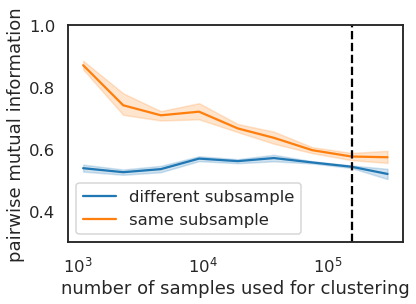

In [91]:
sns.set_style('white')
sns.set_context('talk')

g = sns.lineplot(data=cur_df, x='num', y='mi_score', hue='type', ci=95, markers='o')
g.legend_.set_title(None)
g.set(xscale="log")
g.axvline(len(clus.cluster_mpp.data('latent')), c='black', ls='--')
g.set_xlabel('number of samples used for clustering')
g.set_ylim(0.3,1)
g.set_ylabel('pairwise mutual information')
plt.savefig(fig_dir/'cluster_subsampling_mutual_information.png', dpi=300, bbox_inches='tight')

### Old: plot mutual information with old var scores
this includes same cluster comparisons for both types, which is why "different subsamples" are higher here

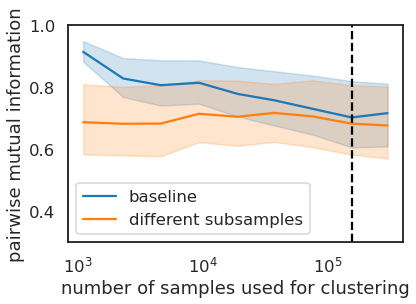

In [55]:
df_varleiden = pd.read_csv(fig_dir/'leiden_subsampling_varleiden.csv', index_col=0)
df_varsub = pd.read_csv(fig_dir/'leiden_subsampling_varsub.csv', index_col=0)
df_varsubleiden = pd.read_csv(fig_dir/'leiden_subsampling_varsubleiden.csv', index_col=0)

sns.set_style('white')
sns.set_context('talk')

sns.lineplot(data=df_varleiden, x='num', y='mi_score', ci=95, label='baseline', markers='o')
g = sns.lineplot(data=df_varsubleiden, x='num', y='mi_score', ci=95, label='different subsamples', markers='o')
g.set(xscale="log")
g.axvline(len(clus.cluster_mpp.data('latent')), c='black', ls='--')
g.set_xlabel('number of samples used for clustering')
g.set_ylim(0.3,1)
g.set_ylabel('pairwise mutual information')
plt.savefig(fig_dir/'cluster_subsampling_mutual_information.png', dpi=300, bbox_inches='tight')

### cluster stability: comparing clusters to final clustering 
- compare distributions of homogeneity scores, NMI and ARI for different subsamples

In [14]:
# compute homogeneity scores
clustering = clus.cluster_mpp.data('clustering_res0.5')
clusters = np.unique(clustering)
cl_list = [c for c in df.columns if 'cl_' in c]

comp = {
    'homogeneity_score': [],
    'mi_score': [],
    'rand_score': [],
    'num': [],
    'leiden_seed': [],
    'sub_seed': [],
}


for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    num = int(num)
    print(num, leiden_seed, sub_seed)
    comp['homogeneity_score'].append(metrics.homogeneity_score(clustering, df[c1]))
    comp['rand_score'].append(metrics.adjusted_rand_score(clustering, df[c1]))
    comp['mi_score'].append(metrics.adjusted_mutual_info_score(clustering, df[c1]))
    comp['num'].append(num)
    comp['leiden_seed'].append(leiden_seed)
    comp['sub_seed'].append(sub_seed)
        
df_comp = pd.DataFrame(comp)
df_comp.to_csv(fig_dir/'cluster_subsampling_compare_to_original_scores.csv')

9300 0 sub0
9300 0 sub1
9300 0 sub2
9300 0 sub3
9300 0 sub4
4600 0 sub0
4600 0 sub1
4600 0 sub2
4600 0 sub3
4600 0 sub4
2300 0 sub0
2300 0 sub1
2300 0 sub2
2300 0 sub3
2300 0 sub4
1100 0 sub0
1100 0 sub1
1100 0 sub2
1100 0 sub3
1100 0 sub4
300000 0 sub0
300000 0 sub1
300000 0 sub2
300000 0 sub3
300000 0 sub4
154906 0 sub0
154906 0 sub1
154906 0 sub2
154906 0 sub3
154906 0 sub4
75000 0 sub0
75000 0 sub1
75000 0 sub2
75000 0 sub3
75000 0 sub4
37000 0 sub0
37000 0 sub1
37000 0 sub2
37000 0 sub3
37000 0 sub4
19000 0 sub0
19000 0 sub1
19000 0 sub2
19000 0 sub3
19000 0 sub4
300000 1 sub0
300000 2 sub0
300000 3 sub0
300000 4 sub0
154906 1 sub0
154906 2 sub0
154906 3 sub0
154906 4 sub0
75000 1 sub0
75000 2 sub0
75000 3 sub0
75000 4 sub0
37000 1 sub0
37000 2 sub0
37000 3 sub0
37000 4 sub0
19000 1 sub0
19000 2 sub0
19000 3 sub0
19000 4 sub0
9300 1 sub0
9300 2 sub0
9300 3 sub0
9300 4 sub0
4600 1 sub0
4600 2 sub0
4600 3 sub0
4600 4 sub0
2300 1 sub0
2300 2 sub0
2300 3 sub0
2300 4 sub0
1100 1 sub0
1

In [8]:
def plot_scores_with_ci(df, x='cl', y='homogeneity_score', ylabel=None, markers='o', legend=True, add_asterix=[]):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    g_cat = sns.stripplot(x=x, y=y, hue="type", data=df, ax=ax, dodge=0.6, jitter=True, zorder=10, linewidth=1, edgecolor='white', color='black')
    g = sns.pointplot(data=df, x=x, y=y, hue='type', dodge=0.6, ax=ax, linestyles='', ci='sd', markers=markers, color='black')
    #g = sns.boxplot(data=df, x='cl', y='homogeneity_score', hue='type', bootstrap=10000, notch=True)
    if ylabel is not None:
        g.set(ylabel=ylabel)
    g.legend_.set_title(None)

    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[5:], labels[5:], bbox_to_anchor=(1, 1), loc=2)
    
    xticklabels = g.get_xticklabels()
    if len(add_asterix)>0:
        for t in xticklabels:
            if t.get_text() in add_asterix:
                t.set_text(f'{t.get_text()} *')
    g.set_xticklabels(xticklabels,
                              rotation=45, 
                             horizontalalignment='center')
    g.tick_params(labelsize=25)
    g.set_xlabel(g.get_xlabel(), fontsize=25)
    g.set_ylabel(g.get_ylabel(), fontsize=25)
    if not legend:
        g.legend_.remove()
    
    
    return g

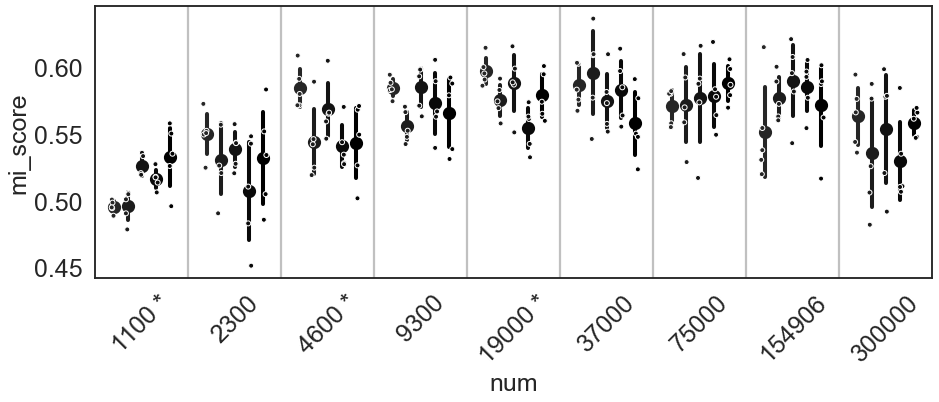

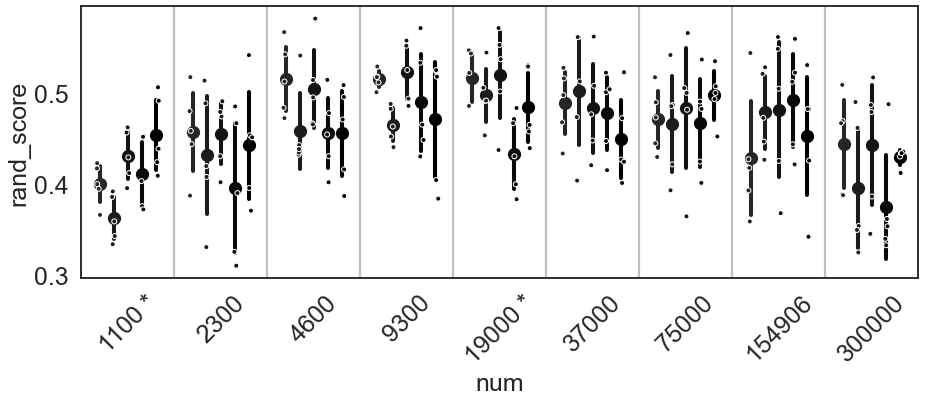

In [12]:
df_comp = pd.read_csv(fig_dir/'cluster_subsampling_compare_to_original_scores.csv')

cur_df = df_comp
cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {}'.format(x.replace('sub', '')))

g = plot_scores_with_ci(cur_df, x='num', y='mi_score', legend=False, add_asterix=['1100', '4600', '19000'])
for i in range(8):
    g.axvline(0.5+i, color='silver')
#plt.savefig(fig_dir/'cluster_subsampling_compare_to_original_mi_score.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir/'cluster_subsampling_compare_to_original_mi_score.pdf', dpi=300, bbox_inches='tight')
g = plot_scores_with_ci(cur_df, x='num', y='rand_score', legend=False, add_asterix=['1100', '19000'])
for i in range(8):
    g.axvline(0.5+i, color='silver')
#plt.savefig(fig_dir/'cluster_subsampling_compare_to_original_rand_score.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir/'cluster_subsampling_compare_to_original_rand_score.pdf', dpi=300, bbox_inches='tight')

In [50]:
# ensure that F-stat from results is showing joint f-test checking if all covariates together are significant
#print(results.summary())
#f_test = results.f_test(','.join(f'({idx}=0)' for idx in results.pvalues.index[1:]))
#print(f_test)

In [14]:
# check pvalues if subsample is significant predictor of scores at each num
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_comp = pd.read_csv(fig_dir/'cluster_subsampling_compare_to_original_scores.csv')

stats = {'score': [], 'num': [], 'fstat': [], 'pval': [], 'anova': []}
for score in ['mi_score', 'rand_score']:
    # fit regression model
    df_comp['sub_seed_num'] = df_comp[['sub_seed', 'num']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    for num in np.unique(df_comp['num']):
        cur_df = df_comp[df_comp['num']==num]
        # use sum contrast coding: https://www.unifyingdatascience.org/html/interpreting_indicator_vars.html
        results = smf.ols(f'{score} ~ C(sub_seed_num, Sum)', data=cur_df).fit()
        stats['score'].append(score)
        stats['num'].append(num)
        stats['fstat'].append(results.fvalue)
        stats['pval'].append(results.f_pvalue)
        # test significance of categorical predictor that is not included in the model (sub4)
        #psub4 = results.f_test(f'-C(sub_seed_num, Sum)[S.sub0_{num}] - -C(sub_seed_num, Sum)[S.sub1_{num}] - -C(sub_seed_num, Sum)[S.sub2_{num}]- -C(sub_seed_num, Sum)[S.sub3_{num}] = 0').pvalue
        #stats['pvalues'].append(np.array(list(results.pvalues[1:]) + [float(psub4)]))
        anova_table = sm.stats.anova_lm(results, typ=2)
        stats['anova'].append(anova_table['PR(>F)']['C(sub_seed_num, Sum)'])

        
        
df_stats = pd.DataFrame(stats)
#df_stats.to_csv(fig_dir/'cluster_subsampling_compare_to_original_stats.csv')
df_stats['significant'] =  df_stats['anova'] < 0.05 # df_stats['pvalues'].apply(lambda x: (x<0.05).any())  #df_stats['pval'] < 0.05
df_stats

,score,num,fstat,pval,anova,significant
0,mi_score,1100,8.441704,0.000369,0.000369,True
1,mi_score,2300,1.383927,0.275158,0.275158,False
2,mi_score,4600,3.522636,0.024794,0.024794,True
3,mi_score,9300,2.005833,0.132445,0.132445,False
4,mi_score,19000,4.451194,0.009805,0.009805,True
5,mi_score,37000,1.562397,0.222894,0.222894,False
6,mi_score,75000,0.339257,0.848234,0.848234,False
7,mi_score,154906,1.340564,0.289585,0.289585,False
8,mi_score,300000,0.933886,0.464393,0.464393,False
9,rand_score,1100,5.495649,0.003754,0.003754,True


### cluster stability: comparing clusters to final clustering -- raw clustering -- per cluster -- old
- compare distributions of homogeneity scores for different subsamples. 
- Do these distributions vary significantly?

In [74]:
# compute homogeneity scores
clustering = clus.cluster_mpp.data('clustering_res0.5')
clusters = np.unique(clustering)
cl_list = [c for c in df.columns if 'cl_' in c]

comp = {
    'homogeneity_score': [],
    'num': [],
    'cl': [],
    'leiden_seed': [],
    'sub_seed': [],
}


for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    num = int(num)
    #if num != len(clus.cluster_mpp.data('latent'))):
    #    continue
    #if leiden_seed != '0':
    #    continue
    print(num, leiden_seed, sub_seed)
    for cl in clusters:
        #print(num, leiden_seed, sub_seed, cl)
        comp['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp['num'].append(num)
        comp['cl'].append(cl)
        comp['leiden_seed'].append(leiden_seed)
        comp['sub_seed'].append(sub_seed)
        
df_comp = pd.DataFrame(comp)
df_comp.to_csv(fig_dir/'cluster_subsampling_homgeneity_scores.csv')

9300 0 sub0
9300 0 sub1
9300 0 sub2
9300 0 sub3
9300 0 sub4
4600 0 sub0
4600 0 sub1
4600 0 sub2
4600 0 sub3
4600 0 sub4
2300 0 sub0
2300 0 sub1
2300 0 sub2
2300 0 sub3
2300 0 sub4
1100 0 sub0
1100 0 sub1
1100 0 sub2
1100 0 sub3
1100 0 sub4
300000 0 sub0
300000 0 sub1
300000 0 sub2
300000 0 sub3
300000 0 sub4
154906 0 sub0
154906 0 sub1
154906 0 sub2
154906 0 sub3
154906 0 sub4
75000 0 sub0
75000 0 sub1
75000 0 sub2
75000 0 sub3
75000 0 sub4
37000 0 sub0
37000 0 sub1
37000 0 sub2
37000 0 sub3
37000 0 sub4
19000 0 sub0
19000 0 sub1
19000 0 sub2
19000 0 sub3
19000 0 sub4
300000 1 sub0
300000 2 sub0
300000 3 sub0
300000 4 sub0
154906 1 sub0
154906 2 sub0
154906 3 sub0
154906 4 sub0
75000 1 sub0
75000 2 sub0
75000 3 sub0
75000 4 sub0
37000 1 sub0
37000 2 sub0
37000 3 sub0
37000 4 sub0
19000 1 sub0
19000 2 sub0
19000 3 sub0
19000 4 sub0
9300 1 sub0
9300 2 sub0
9300 3 sub0
9300 4 sub0
4600 1 sub0
4600 2 sub0
4600 3 sub0
4600 4 sub0
2300 1 sub0
2300 2 sub0
2300 3 sub0
2300 4 sub0
1100 1 sub0
1

AttributeError: module 'pandas' has no attribute 'to_csv'

In [83]:
df_comp = pd.read_csv(fig_dir/'cluster_subsampling_homgeneity_scores.csv', index_col=0)

/tmp/ipykernel_32108/4073039124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=150k)'.format(x.replace('sub', '')))


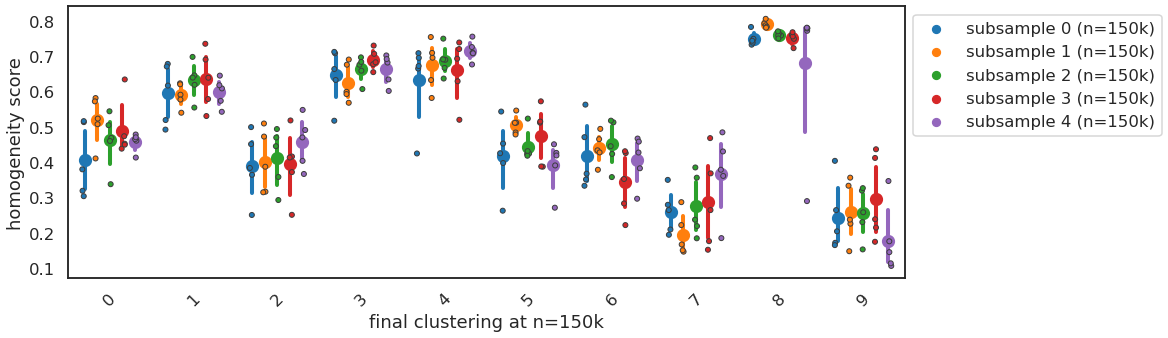

In [84]:
# plot 
sns.set_style('white')
sns.set_context('talk')

cur_df = df_comp[df_comp['num'].isin([154906])]
cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=150k)'.format(x.replace('sub', '')))
g = plot_homogeneity_by_cluster(cur_df)
g.set(xlabel='final clustering at n=150k')
plt.savefig(fig_dir/'cluster_subsampling_homogeneity_score_150k.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_32108/361247669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=75k)'.format(x.replace('sub', '')))


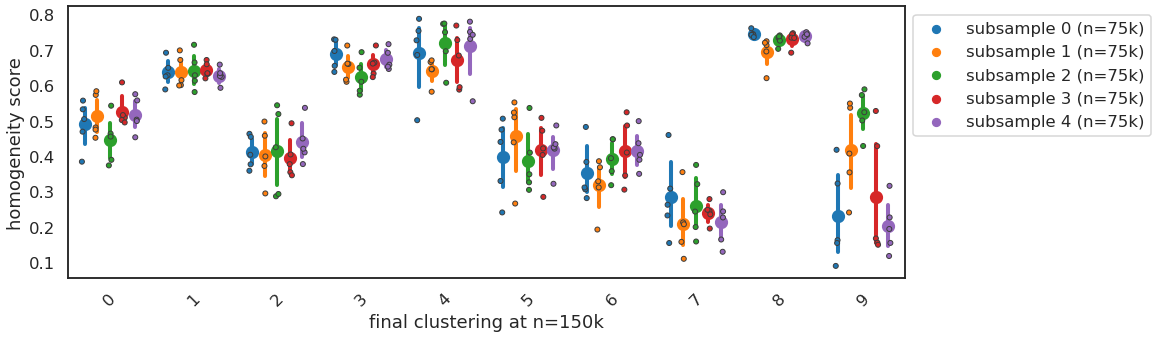

In [85]:
cur_df = df_comp[df_comp['num'].isin([75000])]
cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=75k)'.format(x.replace('sub', '')))
g = plot_homogeneity_by_cluster(cur_df)
g.set(xlabel='final clustering at n=150k')
plt.savefig(fig_dir/'cluster_subsampling_homogeneity_score_75k.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_32108/1636178217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=300k)'.format(x.replace('sub', '')))


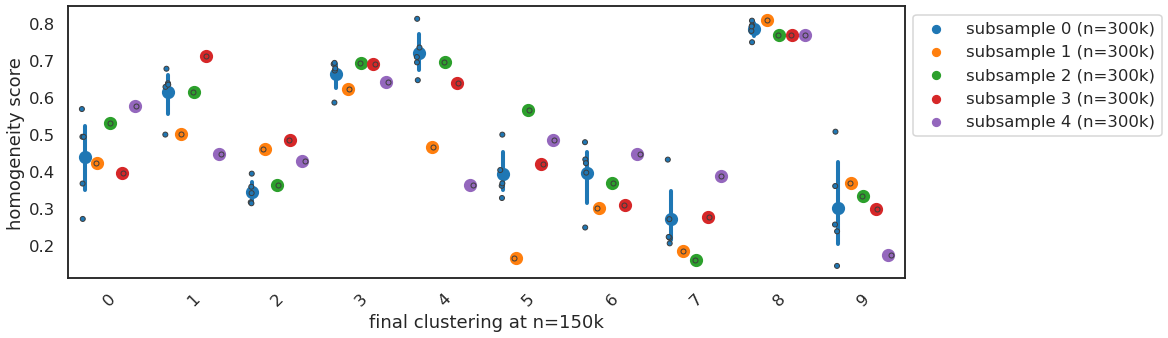

In [86]:
cur_df = df_comp[df_comp['num'].isin([300000])]
cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=300k)'.format(x.replace('sub', '')))
g = plot_homogeneity_by_cluster(cur_df)
g.set(xlabel='final clustering at n=150k')
plt.savefig(fig_dir/'cluster_subsampling_homogeneity_score_300k.png', dpi=300, bbox_inches='tight')

In [29]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp

for num in [154906, 75000]:
    print(num)
    stats_comp = {'cl':[], 'pval': [], 'subsample1': [], 'subsample2': []}
    for cl in clusters:
        cur_df = df_comp[df_comp['num'].isin([num])]
        cur_df = cur_df[cur_df['cl'] == cl]
        for sub_seed1 in ['sub0', 'sub1', 'sub2', 'sub3', 'sub4']:
            samples1 = list(cur_df[cur_df['sub_seed'] == sub_seed1]['homogeneity_score'])
            for sub_seed2 in ['sub0', 'sub1', 'sub2', 'sub3', 'sub4']:
                if sub_seed1 == sub_seed2:
                    continue
                samples2 = list(cur_df[cur_df['sub_seed'] == sub_seed2]['homogeneity_score'])
                #print(sub_seed1, sub_seed2, cl)
                #print(samples1, samples2)
                stat, pval = ks_2samp(samples1, samples2, alternative='two-sided', mode='auto')
                stats_comp['cl'].append(cl)
                stats_comp['subsample1'].append(sub_seed1)
                stats_comp['subsample2'].append(sub_seed2)
                stats_comp['pval'].append(pval)
    # bonferroni correction for multiple testing inside each cluster (10 tests per cluster)
    # could also correct for all tests done, this would be even more stingent
    stats_comp['pval_cor'] = np.array(stats_comp['pval'])*10 #multipletests(stats_comp['pval'], method='bonferroni')[1]
    significant_diffs = np.where(np.array(stats_comp['pval_cor']) < 0.05)[0]
    print(significant_diffs)
    print(np.array(stats_comp['cl'])[significant_diffs])
    print(np.array(stats_comp['subsample1'])[significant_diffs])
    print(np.array(stats_comp['subsample2'])[significant_diffs])
# no significantly different distributions after p-value correction for multiple testing

154906
[]
[]
[]
[]
75000
[]
[]
[]
[]


### cluster stability: compare clusters to final annotated clustering per cluster
- use homogeneity scores to assess how well clustering could be recovered

In [32]:
def annotate_clustering(clustering, annotation, cluster_name, annotation_col=None):
    if annotation_col is None:
        return clustering
    if cluster_name == annotation_col:
        return clustering
    return np.array(annotation.set_index(cluster_name)[annotation_col].loc[clustering])

clustering = clus.cluster_mpp.data('clustering_res0.5')
cl_list = [c for c in df.columns if 'cl_' in c]
clustering = annotate_clustering(clustering, clus.cluster_annotation, 'clustering_res0.5', annotation_col='annotation')
clusters = np.unique(clustering)

In [33]:
# compute homogeneity scores
comp = {
    'homogeneity_score': [],
    'num': [],
    'cl': [],
    'leiden_seed': [],
    'sub_seed': [],
}


for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    num = int(num)
    if num != len(clus.cluster_mpp.data('latent')):  # only need to compute for clustering at same size
        continue
    #if leiden_seed != '0':
    #    continue
    print(num, leiden_seed, sub_seed)
    for cl in clusters:
        #print(num, leiden_seed, sub_seed, cl)
        comp['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp['num'].append(num)
        comp['cl'].append(cl)
        comp['leiden_seed'].append(leiden_seed)
        comp['sub_seed'].append(sub_seed)
        
df_comp = pd.DataFrame(comp)
df_comp.to_csv(fig_dir/'cluster_subsampling_homgeneity_scores_annotated.csv')

154906 0 sub0
154906 0 sub1
154906 0 sub2
154906 0 sub3
154906 0 sub4
154906 1 sub0
154906 2 sub0
154906 3 sub0
154906 4 sub0
154906 1 sub1
154906 2 sub1
154906 3 sub1
154906 4 sub1
154906 1 sub2
154906 2 sub2
154906 3 sub2
154906 4 sub2
154906 1 sub3
154906 2 sub3
154906 3 sub3
154906 4 sub3
154906 1 sub4
154906 2 sub4
154906 3 sub4
154906 4 sub4


In [10]:
df_comp = pd.read_csv(fig_dir/'cluster_subsampling_homgeneity_scores_annotated.csv', index_col=0)

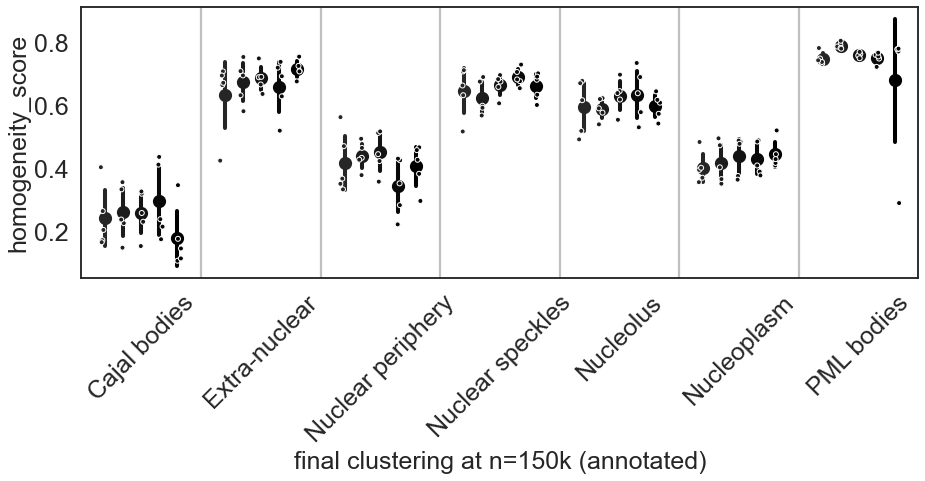

In [11]:
cur_df = df_comp[df_comp['num'].isin([154906])]
cur_df['type'] = cur_df['sub_seed'].apply(lambda x: 'subsample {} (n=150k)'.format(x.replace('sub', '')))
g = plot_scores_with_ci(cur_df, x='cl', y='homogeneity_score', legend=False)
g.set(xlabel='final clustering at n=150k (annotated)')
for i in range(6):
    g.axvline(0.5+i, color='silver')
#plt.savefig(fig_dir/'cluster_subsampling_homogeneity_score_annotated_150k.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir/'cluster_subsampling_homogeneity_score_annotated_150k.pdf', dpi=300, bbox_inches='tight')

#### Homogeneity score for each cluster over all samples

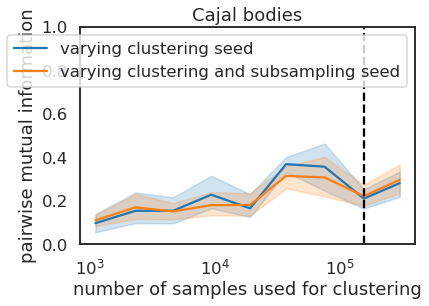

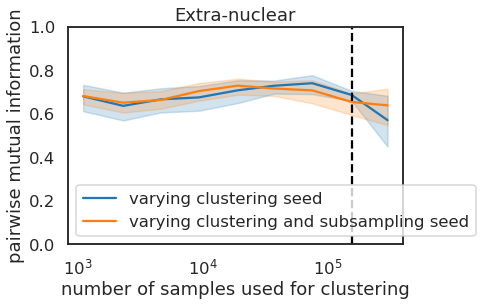

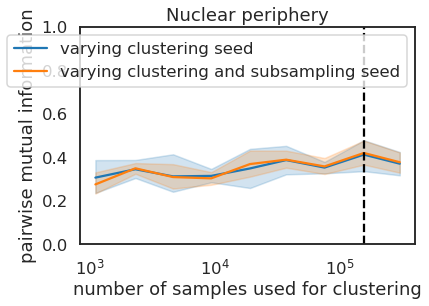

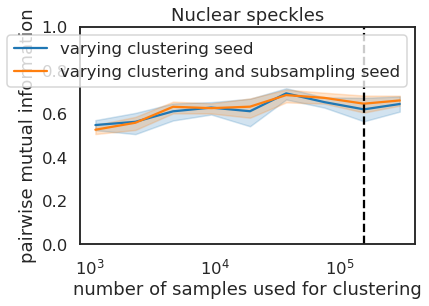

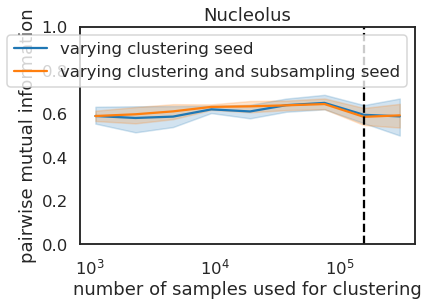

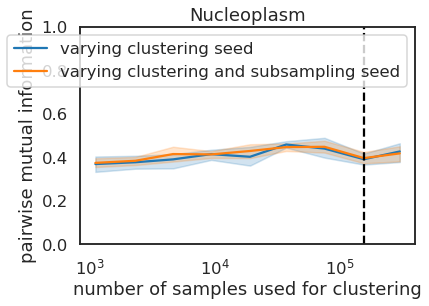

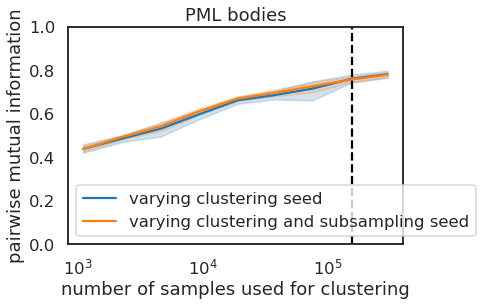

In [75]:
df_varsubleiden['num'] = df_varsubleiden['num'].astype(int)
df_varsub['num'] = df_varsub['num'].astype(int)

for cl in clusters:
    cur_varsub = df_varsub[df_varsub['cl'] == cl]
    cur_varsubleiden = df_varsubleiden[df_varsubleiden['cl'] == cl]
    
    plt.figure()
    sns.lineplot(data=cur_varsub, x='num', y='homogeneity_score', ci=95, label='varying clustering seed')
    g = sns.lineplot(data=cur_varsubleiden, x='num', y='homogeneity_score', ci=95, label='varying clustering and subsampling seed')
    g.set(xscale="log")
    g.axvline(len(clus.cluster_mpp.data('latent')), c='black', ls='--')
    g.set_xlabel('number of samples used for clustering')
    g.set_ylim(0,1)
    g.set_ylabel('pairwise mutual information')
    g.set_title(cl)

In [65]:
df_varsub

,homogeneity_score,num,cl,type
0,0.264298,154906,Cajal bodies,varying subsampling seeds
1,0.709150,154906,Extra-nuclear,varying subsampling seeds
2,0.367629,154906,Nuclear periphery,varying subsampling seeds
3,0.517679,154906,Nuclear speckles,varying subsampling seeds
4,0.678758,154906,Nucleolus,varying subsampling seeds
5,0.395284,154906,Nucleoplasm,varying subsampling seeds
6,0.733220,154906,PML bodies,varying subsampling seeds
7,0.147803,154906,Cajal bodies,varying subsampling seeds
8,0.632970,154906,Extra-nuclear,varying subsampling seeds
9,0.433755,154906,Nuclear periphery,varying subsampling seeds
